In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt

import settings


TITLES_DTYPE = {
    'startYear'         : 'string',
    'titleType'         : 'string',
    'primaryTitle'      : 'string',
    'directorName'      : 'string',
    'genres'            : 'object',
    'averageRating'     : 'float',
    'numVotes'          : 'int',
    'runtimeMinutes'    : 'int',
}

rename_map = {
    'averageRating'     : 'Prosječna ocjena',
    'numVotes'          : 'Broj glasova',
    'numVotes_n'        : 'Broj glasova (n*)',
    'titleType'         : 'Tip naslova',
    'primaryTitle'      : 'Naziv naslova',
    'startYear'         : 'Godina',
    'runtimeMinutes'    : 'Trajanje (min)',
    'runtimeMinutes_n'  : 'Trajanje (min) (n*)',
    'genres'            : 'Žanrovi',
}

theme = {
    'primary': '#F5C611',
    'secondary': '#DEDDB8',
    'alternative': '#302000'
}

titles_df = pd.read_csv(os.path.join(settings.DATASET_DIR, 'master.csv'), dtype=TITLES_DTYPE)
titles_df = titles_df.loc[titles_df['startYear'] < '2022']
titles_df['genres'] = titles_df['genres'].apply(eval)

titles_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456611 entries, 0 to 457438
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   startYear       456611 non-null  string 
 1   titleType       456611 non-null  string 
 2   primaryTitle    456611 non-null  string 
 3   directorName    456611 non-null  string 
 4   genres          456611 non-null  object 
 5   averageRating   456611 non-null  float64
 6   numVotes        456611 non-null  int32  
 7   runtimeMinutes  456611 non-null  int32  
dtypes: float64(1), int32(2), object(1), string(4)
memory usage: 27.9+ MB


Prikaz broja naslova po njihovom tipu. Najveći je broj tipa film (250000), a najmanji tipa video (manje od 50000).

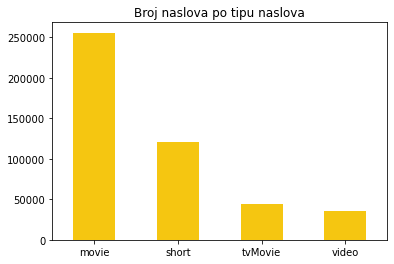

In [2]:
titles_df.titleType.value_counts() \
    .plot.bar(title='Broj naslova po tipu naslova', color=theme['primary'], rot=0)
plt.show()

Prikaz prosječne ocjene po tipu naslova. Najveći prosjek imaju kratki filmovi (kraći od 40 minuta), a najmanji prosjek imaju filmovi. Pretpostavka: Što je veći broj uzoraka, opada njihova kvaliteta (prosječna ocjena).

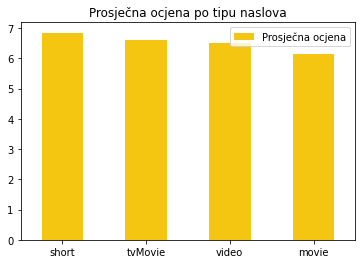

In [3]:
titles_df[['titleType', 'averageRating']]\
    .groupby('titleType').mean('averageRating') \
    .sort_values('averageRating', ascending=False).rename(columns=rename_map) \
    .plot.bar(title="Prosječna ocjena po tipu naslova", color=theme['primary'], rot=0)
plt.xlabel(None)
plt.show()

Prikaz ukupnog broja ocjenjenih filmova po godini (od 2002. do 2021.) u usporedbi s ukupnim brojem ocjena za svaku godinu. Zanimljive su nam godine 2020. i 2021. za usporedbu. Iako u 2020. godini ima otprilike 2000 glasova više od 2021. godine, možemo vidjeti da u 2021. godini imamo veći broj glasova.

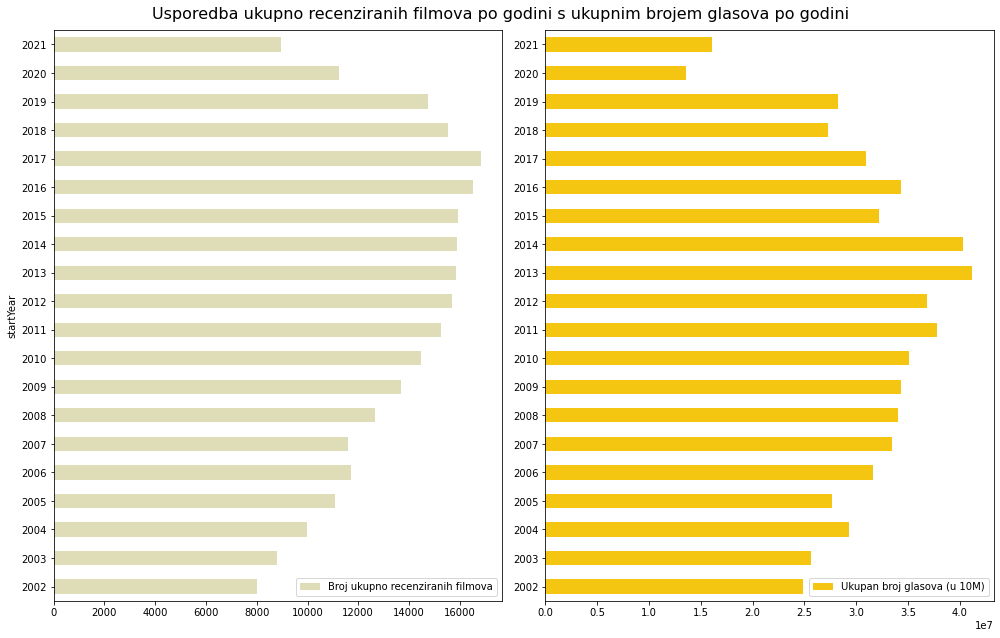

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(14, 9))

titles_df.groupby('startYear').size() \
    .sort_index(ascending=False).head(20)[::-1] \
    .plot.barh(ax=ax[0], color=theme['secondary'])
ax[0].legend(['Broj ukupno recenziranih filmova'], loc='lower right')

titles_df[['startYear', 'numVotes']].groupby('startYear').sum('numVotes') \
    .sort_index(ascending=False).head(20)[::-1] \
    .plot.barh(ax=ax[1], color=theme['primary'])
ax[1].legend(['Ukupan broj glasova (u 10M)'], loc='lower right')
ax[1].set_ylabel(None)

fig.suptitle('Usporedba ukupno recenziranih filmova po godini s ukupnim brojem glasova po godini', fontsize=16)
fig.tight_layout()
plt.show()

Prikaz utjecaja duljine filma (u minutama) i broja glasova na prosječnu ocjenu filma.

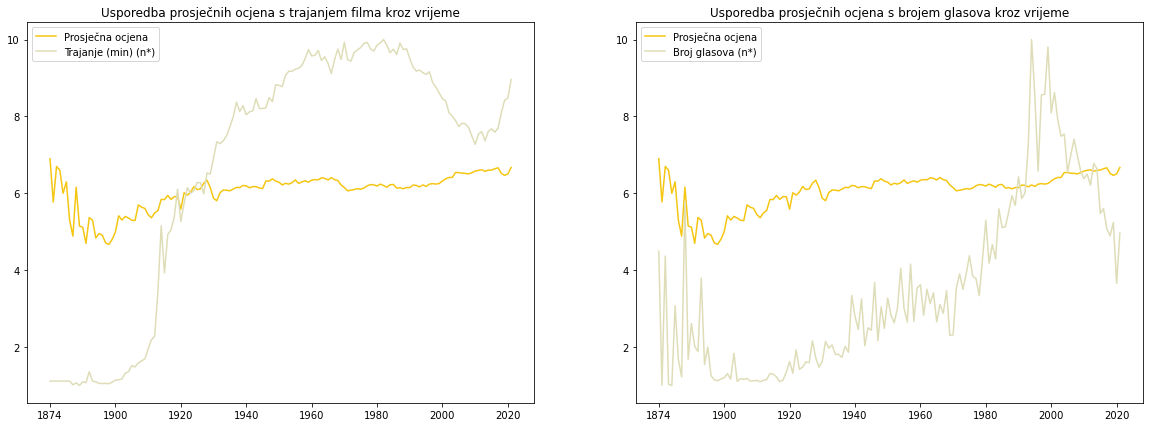

In [5]:
from sklearn.preprocessing import MinMaxScaler

normalizer = MinMaxScaler((1, 10))

fig, ax = plt.subplots(ncols=2, figsize=(20, 7))

yearly_ratings_df = titles_df.rename(columns=dict(startYear='Godina')).groupby('Godina').mean()
yearly_ratings_df['numVotes_n'] = normalizer.fit_transform(yearly_ratings_df[['numVotes']])
yearly_ratings_df['runtimeMinutes_n'] = normalizer.fit_transform(yearly_ratings_df[['runtimeMinutes']])


yearly_ratings_df[['averageRating', 'runtimeMinutes_n']] \
    .rename(columns=rename_map).plot(ax=ax[0], color=theme.values())
ax[0].set_title('Usporedba prosječnih ocjena s trajanjem filma kroz vrijeme')
ax[0].set_xlabel(None)

yearly_ratings_df[['averageRating', 'numVotes_n']] \
    .rename(columns=rename_map).plot(ax=ax[1], color=theme.values())
ax[1].set_title('Usporedba prosječnih ocjena s brojem glasova kroz vrijeme')
ax[1].set_xlabel(None)


plt.show()

Definiranje data frame-a koji se sastoji od filmova od 1970. godine do danas. Sortiran je po broju ocjena i prosječnoj ocjeni.

In [6]:
movie_titles_df = titles_df.loc[(titles_df['titleType'] == 'movie') & (titles_df['startYear'] >= '1970')]
movie_titles_df.sort_values(['numVotes', 'averageRating'], ascending=False).head(20).reset_index(drop=True)

,startYear,titleType,primaryTitle,directorName,genres,averageRating,numVotes,runtimeMinutes
0,1994,movie,The Shawshank Redemption,Frank Darabont,[Drama],9.3,2547412,142
1,2008,movie,The Dark Knight,Christopher Nolan,"[Action, Crime, Drama]",9.0,2497809,152
2,2010,movie,Inception,Christopher Nolan,"[Action, Adventure, Sci-Fi]",8.8,2237262,148
3,1999,movie,Fight Club,David Fincher,[Drama],8.8,2005358,139
4,1994,movie,Forrest Gump,Robert Zemeckis,"[Drama, Romance]",8.8,1965749,142
5,1994,movie,Pulp Fiction,Quentin Tarantino,"[Crime, Drama]",8.9,1959207,154
6,1999,movie,The Matrix,Lana Wachowski,"[Action, Sci-Fi]",8.7,1837591,136
7,2001,movie,The Lord of the Rings: The Fellowship of the Ring,Peter Jackson,"[Action, Adventure, Drama]",8.8,1777729,178
8,2003,movie,The Lord of the Rings: The Return of the King,Peter Jackson,"[Action, Adventure, Drama]",8.9,1755900,201
9,1972,movie,The Godfather,Francis Ford Coppola,"[Crime, Drama]",9.2,1752303,175


Definiranje data frame-a za žanrove. Sastoji se od imena redatelja, žanra i prosječne ocjene.

In [7]:
genres_df = movie_titles_df[['directorName', 'genres', 'averageRating']] \
    .explode('genres').reset_index(drop=True)
genres_df.sample(10)

,directorName,genres,averageRating
96629,Al Mamar,Horror,3.6
132762,This Lüscher,Comedy,4.9
52162,Adoor Gopalakrishnan,Biography,7.3
36486,Umberto Lenzi,Crime,4.6
153600,Chris Suchorsky,Music,8.3
38770,Michele Massimo Tarantini,Action,5.9
233342,Justin Turcotte,Comedy,6.6
346770,Tarik Hatipoglu,Fantasy,6.3
214132,Yasuo Baba,Drama,5.4
80448,Alfredo B. Crevenna,Comedy,4.8


Prikaz broja filmova po žanrovima. Najviše filmova spada u drame, komedije i dokumentarce. 

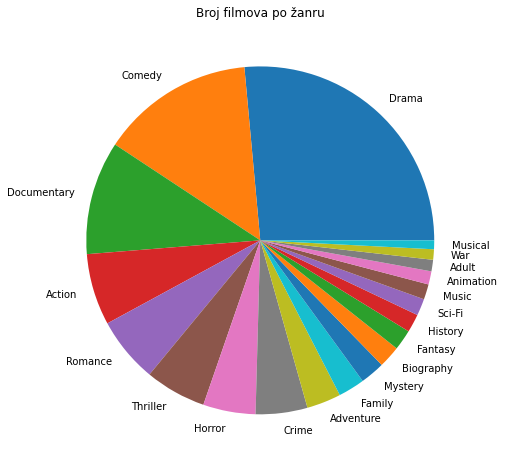

In [8]:
fig, ax = plt.subplots(1, figsize=(8, 8))
fig.set_facecolor('white')

genres_df.genres.value_counts().head(20).plot.pie(ax=ax)
ax.set_title('Broj filmova po žanru')
ax.set_ylabel(None)

plt.show()

Prikaz prosjeka prosječnih ocjena u usporedbi sa sumom prosječnih ocjena.

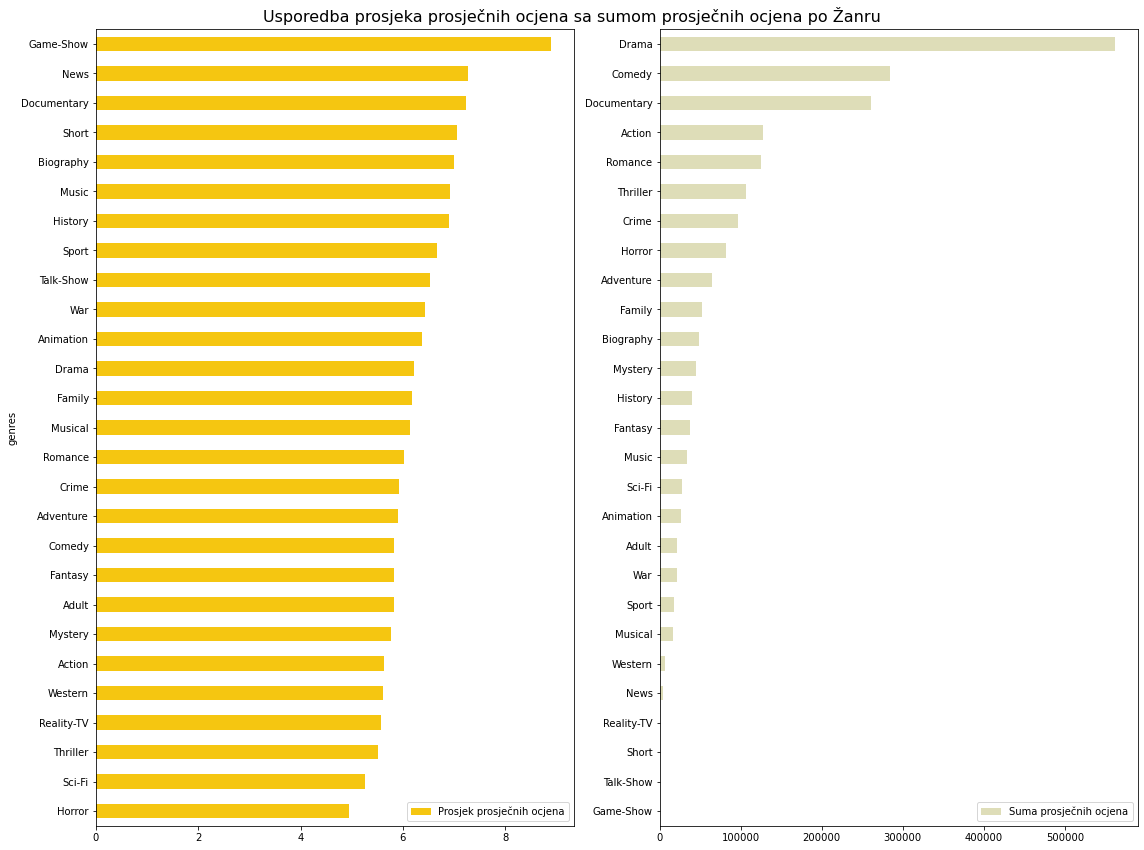

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 12))

genres_df.groupby('genres').mean('averageRating') \
    .sort_values('averageRating').rename(columns=rename_map) \
    .plot.barh(ax=ax[0], color=theme['primary'])
ax[0].legend(['Prosjek prosječnih ocjena'], loc='lower right')

genres_df.groupby('genres').sum('averageRating') \
    .sort_values('averageRating').rename(columns=rename_map) \
    .plot.barh(ax=ax[1], color=theme['secondary'])
ax[1].legend(['Suma prosječnih ocjena'], loc='lower right')
ax[1].set_ylabel(None)

fig.suptitle('Usporedba prosjeka prosječnih ocjena sa sumom prosječnih ocjena po Žanru', fontsize=16)
fig.tight_layout()
plt.show()

Pretpostavka: Što je veći broj uzoraka, opada njihova kvaliteta (prosječna ocjena) 

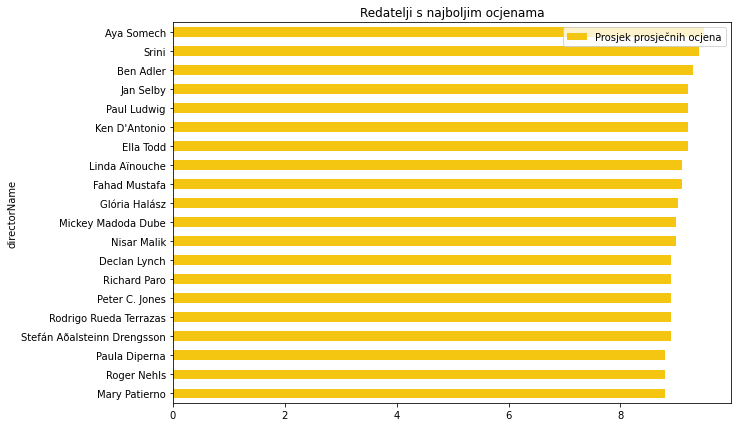

In [10]:
genres_df.groupby('directorName').agg(ratings=('averageRating', 'mean')).sample(1000) \
    .sort_values('ratings', ascending=False).rename(columns=dict(ratings='Prosjek prosječnih ocjena')).head(20)[::-1] \
    .plot.barh(figsize=(10, 7), title='Redatelji s najboljim ocjenama', color=theme['primary'])
plt.show()

Prikaz redatelja, žanra broja glasova i prosječne ocjene za navedene filmove.

In [11]:
X_name = ['directorName', 'genres']
y_name = ['averageRating']

movie_titles_df = titles_df.loc[:, X_name + y_name]
directors_idx = {director_name: director_id+1 for director_id, director_name in enumerate(movie_titles_df.directorName.unique())}
movie_titles_df['directorID'] = movie_titles_df['directorName'].transform(lambda x: directors_idx[x])
# movie_titles_df.groupby(['directorName', 'numVotes']).mean('averageRating').sort_index(level='numVotes', ascending=False)
movie_titles_df

,directorName,genres,averageRating,directorID
0,William K.L. Dickson,"[Documentary, Short]",5.7,1
1,Émile Reynaud,"[Animation, Short]",6.0,2
2,Émile Reynaud,"[Animation, Comedy, Romance]",6.5,2
3,Émile Reynaud,"[Animation, Short]",6.0,2
4,William K.L. Dickson,"[Comedy, Short]",6.2,1
...,...,...,...,...
457434,Gabriel Athanasiou,[Comedy],9.3,134490
457435,Azhar Kinoi Lubis,[Drama],8.3,67212
457436,Jason Bradbury,"[Drama, Short]",7.0,65391
457437,Niclas Schmidt,"[Comedy, Horror, Mystery]",5.5,67567


Tablica koja prikazuje u koje žanrove spadaju filmovi za sve redatelje te broj ocjena i prosječnu ocjenu redatelja.

In [12]:
from sklearn.preprocessing import MultiLabelBinarizer

dataset = movie_titles_df.dropna().reset_index(drop=True)

mlb = MultiLabelBinarizer()
mlb_df = pd.DataFrame(mlb.fit_transform(dataset.pop('genres')),
    columns=mlb.classes_,
    index=dataset.index
)
mlb_df

,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456606,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
456607,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
456608,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
456609,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
dataset.join(mlb_df)

,directorName,averageRating,directorID,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,William K.L. Dickson,5.7,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,Émile Reynaud,6.0,2,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,Émile Reynaud,6.5,2,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,Émile Reynaud,6.0,2,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,William K.L. Dickson,6.2,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456606,Gabriel Athanasiou,9.3,134490,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
456607,Azhar Kinoi Lubis,8.3,67212,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
456608,Jason Bradbury,7.0,65391,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
456609,Niclas Schmidt,5.5,67567,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Grupiranje prosječnih ocjena. Ako je prosječna ocjena veća od 8.5 spada u grupu 5, ako se nalazi između 8.5 i 7.5 spada u grupu 4, ako se nalazi između 7.5 i 6 spada u grupu 3, ako se nalazi između 6 i 4.5 spada u grupu 2, a svi ostali spadaju u grupu 1. 

In [14]:
dataset_model = dataset.join(mlb_df)
dataset_model['rating'] = dataset_model.averageRating.transform(lambda x:
    5 if x >= 8.5 else
    4 if x < 8.5 and x >= 7.5 else
    3 if x < 7.5 and x >= 6 else
    2 if x < 6 and x >= 4.5 else
    1
)
dataset_model = dataset_model.drop(['directorName', 'averageRating'], axis=1)

y_name = ['rating']

X = dataset_model.drop(y_name, axis=1)
y = dataset_model[y_name]

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456611 entries, 0 to 456610
Data columns (total 29 columns):
 #   Column       Non-Null Count   Dtype
---  ------       --------------   -----
 0   directorID   456611 non-null  int64
 1   Action       456611 non-null  int32
 2   Adult        456611 non-null  int32
 3   Adventure    456611 non-null  int32
 4   Animation    456611 non-null  int32
 5   Biography    456611 non-null  int32
 6   Comedy       456611 non-null  int32
 7   Crime        456611 non-null  int32
 8   Documentary  456611 non-null  int32
 9   Drama        456611 non-null  int32
 10  Family       456611 non-null  int32
 11  Fantasy      456611 non-null  int32
 12  Film-Noir    456611 non-null  int32
 13  Game-Show    456611 non-null  int32
 14  History      456611 non-null  int32
 15  Horror       456611 non-null  int32
 16  Music        456611 non-null  int32
 17  Musical      456611 non-null  int32
 18  Mystery      456611 non-null  int32
 19  News         456611 non

In [16]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456611 entries, 0 to 456610
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   rating  456611 non-null  int64
dtypes: int64(1)
memory usage: 3.5 MB


Prikaz broja filmova po definiranim grupama. Najveći je broj onih koji spadaju u grupu 3, odnosno imaju prosječnu ocjenu u rasponu od 6 do 7.5.

<AxesSubplot:xlabel='rating'>

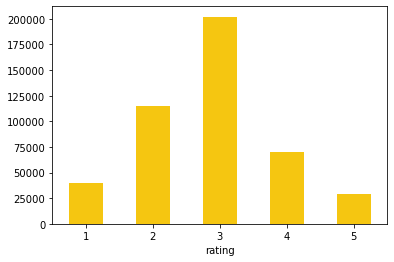

In [17]:
y.groupby('rating')['rating'].size().plot.bar(color=theme['primary'], rot=0)

In [18]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

over_sampler = RandomOverSampler(sampling_strategy={1: 90000, 4: 90000, 5: 90000})
under_sampler = RandomUnderSampler(sampling_strategy={2: 90000, 3: 90000})

over_sampled_X, over_sampled_y = over_sampler.fit_resample(X, y)
balanced_X, balanced_y = under_sampler.fit_resample(over_sampled_X, over_sampled_y)

<AxesSubplot:xlabel='rating'>

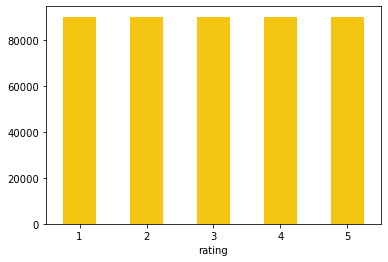

In [19]:
balanced_y.groupby('rating')['rating'].size().plot.bar(color=theme['primary'], rot=0)

In [20]:
from sklearn.model_selection import train_test_split
import model_config


for i, item in enumerate(model_config.CONFIG):
    print("RUN#{} `{}`".format(i+1, item['name']))
    if item['dataset'] == 'balanced':
        X, y = balanced_X, balanced_y
        print("using balanced dataset")
    else:
        print("using original dataset")
    print("params: {}".format(json.dumps(item['params']), indent=2))
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.3,
        random_state=42
    )
    
    Classifier = item['Classifier']
    clf = Classifier(**item['params'])
    
    if Classifier is model_config.MLPClassifier:
        X_train = X_train.values
        X_test = X_test.values
    
    clf.fit(X_train, y_train.values.reshape(1, -1)[0])
    
    item['Classifier'] = clf
    item['train_score'] = round(clf.score(X_train, y_train.values), 2)
    item['test_score'] = round(clf.score(X_test, y_test.values), 2)

    print("- train_score:       {:.2f}".format(item['train_score']))
    print("- test_score:        {:.2f}".format(item['test_score']))
    print("\n")

with open(os.path.join(settings.DATASET_DIR, 'scores.json'), 'w') as f:
    json.dump(model_config.CONFIG, f, indent=4, default=str)

RUN#1 `Decision Tree Classifier`
using balanced dataset
params: {"random_state": null, "max_depth": null}
- train_score:       0.92
- test_score:        0.58


RUN#2 `Decision Tree Classifier`
using original dataset
params: {"random_state": null, "max_depth": null}
- train_score:       0.92
- test_score:        0.57


RUN#3 `Decision Tree Classifier`
using original dataset
params: {"random_state": 420, "max_depth": 10}
- train_score:       0.38
- test_score:        0.38


RUN#4 `Decision Tree Classifier`
using balanced dataset
params: {"random_state": 42, "max_depth": 20}
- train_score:       0.49
- test_score:        0.42


RUN#5 `Decision Tree Classifier`
using original dataset
params: {"random_state": 42, "max_depth": 30}
- train_score:       0.68
- test_score:        0.49


RUN#6 `Random Forest Classifier`
using balanced dataset
params: {"random_state": 42, "max_depth": null, "n_jobs": -1}
- train_score:       0.92
- test_score:        0.57


RUN#7 `Random Forest Classifier`
using 

C:\Users\AndreaHrelja\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


- train_score:       0.20
- test_score:        0.20


RUN#16 `Multinomial Logistic Regression`
using balanced dataset
params: {"random_state": 420, "penalty": "none", "solver": "lbfgs", "multi_class": "multinomial", "max_iter": 500}
- train_score:       0.20
- test_score:        0.20


RUN#17 `Multinomial Logistic Regression`
using original dataset
params: {"random_state": 420, "penalty": "none", "solver": "lbfgs", "multi_class": "multinomial", "max_iter": 500}
- train_score:       0.20
- test_score:        0.20


RUN#18 `Multinomial Logistic Regression`
using balanced dataset
params: {"random_state": 42, "penalty": "l2", "solver": "lbfgs", "multi_class": "multinomial", "max_iter": 500}
- train_score:       0.20
- test_score:        0.20


RUN#19 `Multinomial Logistic Regression`
using original dataset
params: {"random_state": 42, "penalty": "l2", "solver": "lbfgs", "multi_class": "multinomial", "max_iter": 500}
- train_score:       0.20
- test_score:        0.20




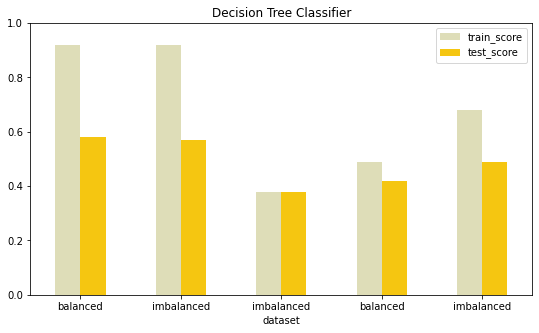

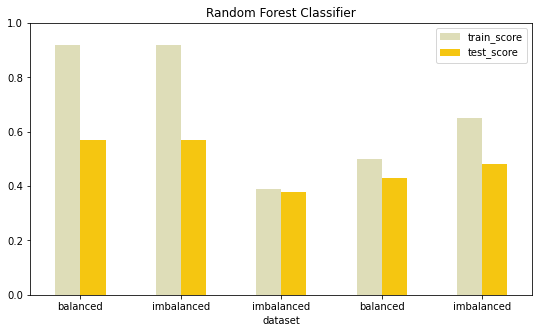

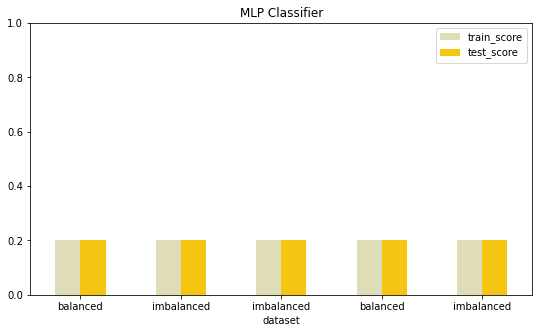

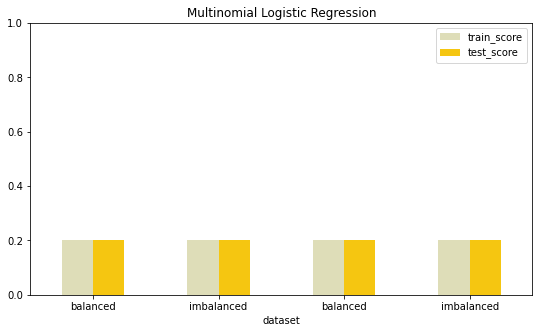

In [21]:
data = [
    {
        'name': item['name'],
        'train_score': item['train_score'],
        'test_score': item['test_score'],
        'dataset': item['dataset']
    } for item in model_config.CONFIG
]

scores_df = pd.DataFrame(data)
for name in scores_df.name.unique():
    scores_df[scores_df['name'] == name] \
        .set_index('dataset').plot.bar(
            title="{}".format(name), rot=0,
            figsize=(9, 5), ylim=(0, 1), color=[
                theme['secondary'],
                theme['primary']
            ]
        )


In [22]:
index = [
    'Christopher Nolan', 
    'Christopher Nolan', 
    'Lamberto Sanfelice'
]

X_to_predict = pd.DataFrame([
    {
        'directorID': directors_idx['Christopher Nolan'],
        'Action':           1,
        'Adult':            0,
        'Adventure':        0,
        'Animation':        0,
        'Biography':        0,
        'Comedy':           0,
        'Crime':            1,
        'Documentary':      0,
        'Drama':            1,
        'Family':           0,
        'Fantasy':          0,
        'Film-Noir':        0,
        'Game-Show':        0,
        'History':          0,
        'Horror':           0,
        'Music':            0,
        'Musical':          0,
        'Mystery':          0,
        'News':             0,
        'Reality-TV':       0,
        'Romance':          0,
        'Sci-Fi':           1,
        'Short':            0,
        'Sport':            0,
        'Talk-Show':        0,
        'Thriller':         0,
        'War':              0,
        'Western':          0,
    },
    {
        'directorID': directors_idx['Christopher Nolan'],
        'Action':           0,
        'Adult':            0,
        'Adventure':        0,
        'Animation':        0,
        'Biography':        0,
        'Comedy':           0,
        'Crime':            0,
        'Documentary':      0,
        'Drama':            1,
        'Family':           0,
        'Fantasy':          1,
        'Film-Noir':        0,
        'Game-Show':        0,
        'History':          0,
        'Horror':           0,
        'Music':            0,
        'Musical':          0,
        'Mystery':          0,
        'News':             0,
        'Reality-TV':       0,
        'Romance':          0,
        'Sci-Fi':           1,
        'Short':            0,
        'Sport':            0,
        'Talk-Show':        0,
        'Thriller':         0,
        'War':              0,
        'Western':          0,
    },
    {
        'directorID': directors_idx['Lamberto Sanfelice'],
        'Action':           0,
        'Adult':            0,
        'Adventure':        0,
        'Animation':        0,
        'Biography':        0,
        'Comedy':           0,
        'Crime':            0,
        'Documentary':      0,
        'Drama':            1,
        'Family':           0,
        'Fantasy':          0,
        'Film-Noir':        0,
        'Game-Show':        0,
        'History':          0,
        'Horror':           0,
        'Music':            0,
        'Musical':          0,
        'Mystery':          0,
        'News':             0,
        'Reality-TV':       0,
        'Romance':          0,
        'Sci-Fi':           0,
        'Short':            0,
        'Sport':            0,
        'Talk-Show':        0,
        'Thriller':         0,
        'War':              0,
        'Western':          0,
    }
], index=index)

for item in model_config.CONFIG:
    clf = item['Classifier']
    if isinstance(clf, model_config.MLPClassifier):
        predictions = clf.predict(X_to_predict.values)
    else:
        predictions = clf.predict(X_to_predict)
    
    print(item['name'])
    if item['dataset'] == 'balanced':
        print("using balanced dataset")
    else:
        print("using imbalanced dataset")
    
    print(item['params'])
    print("- Christopher Nolan (Drama, Action, Crime): ", predictions[0])
    print("- Christopher Nolan (Drama, Fantasy, Sci-Fi): ", predictions[1])
    print("- Lamberto Sanfelice (Drama): ", predictions[2])
    print("\n")

Decision Tree Classifier
using balanced dataset
{'random_state': None, 'max_depth': None}
- Christopher Nolan (Drama, Action, Crime):  1
- Christopher Nolan (Drama, Fantasy, Sci-Fi):  5
- Lamberto Sanfelice (Drama):  2


Decision Tree Classifier
using imbalanced dataset
{'random_state': None, 'max_depth': None}
- Christopher Nolan (Drama, Action, Crime):  1
- Christopher Nolan (Drama, Fantasy, Sci-Fi):  5
- Lamberto Sanfelice (Drama):  2


Decision Tree Classifier
using imbalanced dataset
{'random_state': 420, 'max_depth': 10}
- Christopher Nolan (Drama, Action, Crime):  1
- Christopher Nolan (Drama, Fantasy, Sci-Fi):  3
- Lamberto Sanfelice (Drama):  3


Decision Tree Classifier
using balanced dataset
{'random_state': 42, 'max_depth': 20}
- Christopher Nolan (Drama, Action, Crime):  1
- Christopher Nolan (Drama, Fantasy, Sci-Fi):  3
- Lamberto Sanfelice (Drama):  3


Decision Tree Classifier
using imbalanced dataset
{'random_state': 42, 'max_depth': 30}
- Christopher Nolan (Drama, Act